In [2]:
passportDrive = os.path.join(externalDrives, os.listdir(passport)[0])

NameError: name 'externalDrives' is not defined

In [4]:
workDrive = '/media/ak/WorkDrive'

In [5]:
ActivityCLockData= '/media/ak/My Passport/Experiment Data/ActivityClockData/'
OHLCData= '/media/ak/My Passport/Experiment Data/OHLCData/'
folderList = os.listdir(ActivityCLockData)
OHLCDataList = os.listdir(OHLCData)
ActivityClockDataList = os.listdir(ActivityCLockData)

symbols =['FB1','JB1','FV1','G_1']

In [6]:
## pkl files - these 
folder= '/media/ak/My Passport/Experiment Data/ActivityClockData/'
folderList = os.listdir(folder)

In [ ]:
# put all thes dates of each symbol in the same dictionary

In [7]:

FV1ClocksData = np.sort([s for s in os.listdir(ActivityCLockData) if 'Clocks' in s and ('FV1') in s])
tickBarDictCondensed = dict()
for pklidx in range(0,19):
    pklClockFile = "".join((ActivityCLockData,FV1ClocksData[pklidx]))
    tickBarDF =pickle.load(open(pklClockFile , "rb"))['TickBarDf'] #tickbar
    tickBarDictCondensed[FV1ClocksData[pklidx].split('_')[3]]=tickBarDF [['BidSize', 'QuoteTime','BestBid',
       'TradeTime', 'AskSize','BestAsk', 'TradeVolume', 'TradedTime', 'type',
       'TradePrice', 'TimeStamp', 'milliSeconds','DollarVolume', 'MicroPrice', 'TradeSize', 'DollarVolumeTraded']]


OSError: [Errno 5] Input/output error

In [8]:
keys = list(tickBarDictCondensed.keys())

In [9]:
twoDates = random.sample(set(keys), 2)

In [12]:
X =tickBarDictCondensed[twoDates[0]].MicroPrice.pct_change().dropna()[:10000]
Y =tickBarDictCondensed[twoDates[1]].MicroPrice.pct_change().dropna()[:10000]

In [13]:
print('Shapes of the two dates')
print (X.shape, Y.shape)

feats_p = RealFeatures(X.values.reshape(1,len(X)))
feats_q = RealFeatures(Y.values.reshape(1,len(Y)))
width=1
k = GaussianKernel(10, width) # should have a constructor that does not require to specify cache size

Shapes of the two dates
(10000,) (10000,)


time taken: 205.60074663162231


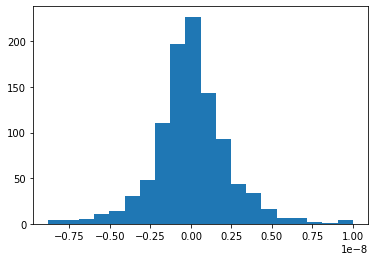

In [14]:

mmd = QuadraticTimeMMD() # should take p and q as argument
mmd.set_p(feats_p)
mmd.set_q(feats_q)
mmd.set_kernel(k)

# this should be able to receive a CSignal abort, made my Python stall a couple of times
#mmd.set_num_null_samples(10000)

start = time.time()
mmd.set_num_null_samples(1000) 
null_samples = mmd.sample_null() # seems to take quite long, and not running on all my cpus (only 2/4 it seems). I havent checked properly, but this is only first impression
print ("time taken:", time.time()-start)
plt.hist(null_samples, bins=20);

In [15]:
# need to make this run on all the CPUs

In [17]:
#mmd.set_null_approximation_method()

num_runs = 20
p_values = np.zeros(num_runs)

last = time.time()
for i in range(num_runs):
    print (i, time.time()-last)
    last = time.time()
    
    # this is a usual use-case: repeating the same experiment multiple times.
    # I guess we can save computation here, e.g. the precomputed kernel matrix
    # .... maybe use some kind of lazy evaluation?
    # also, notice the inhomogeneous times. Is that just by chance? Sometimes there are outliers up to 9s.
    stat = mmd.compute_statistic()
    p_values[i] = mmd.compute_p_value(stat)

0 0.00016880035400390625
1 198.98905110359192
2 197.2857904434204
3 196.5211308002472
4 196.3559467792511
5 195.85497736930847
6 195.46262621879578
7 195.32149815559387
8 196.0120222568512
9 195.33352732658386
10 195.3705813884735
11 196.63407254219055
12 196.72494411468506
13 196.1246280670166
14 196.42718386650085
15 196.37444043159485
16 195.39012455940247
17 196.60053515434265
18 195.73972249031067
19 195.92566061019897


(array([ 0.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

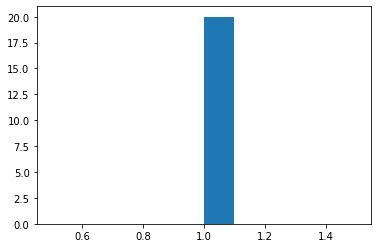

In [19]:
plt.hist(p_values)

time taken: 6.480177164077759
time taken: 28.21870255470276


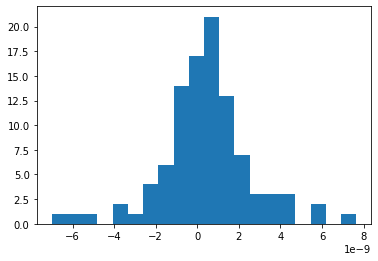

In [23]:
feats_p = RealFeatures(X.values.reshape(1,len(X)))
feats_q = RealFeatures(Y.values.reshape(1,len(Y)))
width=1
k = GaussianKernel(10, width)

joint_features = RealFeatures(np.hstack((X, Y)).reshape(1, len(X)+len(Y)))
k.init(joint_features,joint_features)
start = time.time()
k.get_kernel_matrix()
print ("time taken:", time.time()-start)

mmd = QuadraticTimeMMD()
mmd.set_p(feats_p)
mmd.set_q(feats_q)
mmd.set_kernel(k)

start = time.time()
mmd.set_num_null_samples(100) # Is the kernel matrix precomputed in here? It should be. Why isnt this faster?
# when doing permutation test, is the kernel matrix only computed once and then summed over differently? Or is it copied around?
# what takes the time here?
null_samples = mmd.sample_null()
print("time taken:", time.time()-start)
plt.hist(null_samples, bins=20);

In [27]:

from scipy.spatial.distance import squareform, pdist, cdist

def sq_distances(X,Y=None):
    """
    If Y=None, then this computes the distance between X and itself
    """
    assert(X.ndim==2)

    # IMPLEMENT: compute pairwise distance matrix. Don't use explicit loops, but the above scipy functions
    # if X=Y, use more efficient pdist call which exploits symmetry
    if Y is None:
        sq_dists = squareform(pdist(X, 'sqeuclidean'))
    else:
        assert(Y.ndim==2)
        assert(X.shape[1]==Y.shape[1])
        sq_dists = cdist(X, Y, 'sqeuclidean')

    return sq_dists

def gauss_kernel(X, Y=None, sigma=1.0):
    """
    Computes the standard Gaussian kernel k(x,y)=exp(- ||x-y||**2 / (2 * sigma**2))

    X - 2d array, samples on left hand side
    Y - 2d array, samples on right hand side, can be None in which case they are replaced by X
    
    returns: kernel matrix
    """

    # IMPLEMENT: compute squared distances and kernel matrix
    sq_dists = sq_distances(X,Y)
    K = np.exp(-sq_dists / (2 * sigma**2))
    return K

# IMPLEMENT
def linear_kernel(X, Y):
    return np.dot(X, Y.T)

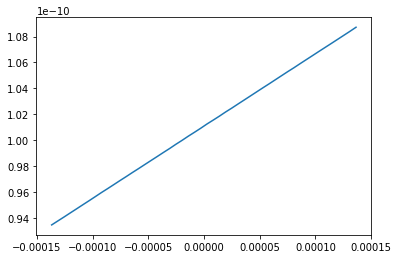

In [32]:
grid = np.linspace(np.min(X), np.max(X))

my_kernel = lambda X,Y : gauss_kernel(X,Y, sigma=0.5)

# IMPLEMENT: evaluate MMD witness function on grid
phi_X = np.mean(my_kernel(X[:,np.newaxis], grid[:,np.newaxis]), axis=0)
phi_Y = np.mean(my_kernel(Y[:,np.newaxis], grid[:,np.newaxis]), axis=0)
witness = phi_X-phi_Y


plt.plot(grid, witness)

# plt.hist(X, alpha=0.5, normed=True)
# plt.hist(Y, alpha=0.5, normed=True);